# 載入必要套件

In [2]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib import font_manager
from sklearn.model_selection import GridSearchCV
import datetime
import pandas as pd

# 蒐集比特幣資料

In [29]:
from binance.client import Client
import pandas as pd
import datetime
from binance.exceptions import BinanceAPIException  # 引入例外處理

# 設定 API 金鑰和密鑰
api_key = 'DfvXtqIiG1BiKiV7ecXjtwuNhwYYEod0f34YwWNy4NKwy5QR0pkO5zDZoNQ83aCT'
api_secret = 'x50YoiJVlm9PoFKSBtmSu63suMJsCcsZqCJG5qZWuikYDsgjmkjkcRSa0Pmmimzm'

# 建立 Binance 客戶端連線
client = Client(api_key, api_secret)

# 初始化資料儲存容器
all_data = []

# 設定初始時間
start_time = int(datetime.datetime(2017, 1, 1).timestamp() * 1000)
end_time = int(datetime.datetime(2024, 12, 31).timestamp() * 1000)  # 可選擇結束時間

# 設定每次請求的資料筆數
limit = 500

# 開始迭代抓取資料
while start_time < end_time:
    try:
        # 下載 K 線圖資料
        klines = client.get_klines(
            symbol='BTCUSDT',
            interval=Client.KLINE_INTERVAL_1DAY,
            startTime=start_time,
            endTime=end_time,
            limit=limit
        )
        
        # 檢查是否有資料
        if len(klines) == 0:
            print("無資料返回，終止迴圈。")
            break  # 或者可以設置繼續迴圈的邏輯

        # 將 K 線資料轉換為 DataFrame
        columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        data = pd.DataFrame(klines, columns=columns)

        # 將時間戳記轉為日期時間格式
        data['open_time'] = pd.to_datetime(data['open_time'], unit='ms')
        data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')

        # 將這批資料加入到結果中
        all_data.append(data)

        # 設定下一次查詢的開始時間為最後一筆資料的結束時間
        start_time = int(data['close_time'].iloc[-1].timestamp() * 1000)  # 下一次查詢的開始時間是當前最後一筆資料的結束時間

    except BinanceAPIException as e:
        print(f"API 請求錯誤: {e}")
        break  # 或者進行重新請求的處理

# 合併所有抓取的資料
if all_data:
    data = pd.concat(all_data, ignore_index=True)
    # 顯示資料
    print(data.head())
else:
    print("未獲取到任何資料。")


無資料返回，終止迴圈。
   open_time           open           high            low          close  \
0 2017-08-17  4261.48000000  4485.39000000  4200.74000000  4285.08000000   
1 2017-08-18  4285.08000000  4371.52000000  3938.77000000  4108.37000000   
2 2017-08-19  4108.37000000  4184.69000000  3850.00000000  4139.98000000   
3 2017-08-20  4120.98000000  4211.08000000  4032.62000000  4086.29000000   
4 2017-08-21  4069.13000000  4119.62000000  3911.79000000  4016.00000000   

          volume              close_time quote_asset_volume  number_of_trades  \
0   795.15037700 2017-08-17 23:59:59.999   3454770.05073206              3427   
1  1199.88826400 2017-08-18 23:59:59.999   5086958.30617151              5233   
2   381.30976300 2017-08-19 23:59:59.999   1549483.73542151              2153   
3   467.08302200 2017-08-20 23:59:59.999   1930364.39032646              2321   
4   691.74306000 2017-08-21 23:59:59.999   2797231.71402728              3972   

  taker_buy_base_asset_volume taker_buy_quot

# 資料處理

In [30]:
data.dtypes

open_time                       datetime64[ns]
open                                    object
high                                    object
low                                     object
close                                   object
volume                                  object
close_time                      datetime64[ns]
quote_asset_volume                      object
number_of_trades                         int64
taker_buy_base_asset_volume             object
taker_buy_quote_asset_volume            object
ignore                                  object
dtype: object

In [31]:
# 將特定欄位轉換為 float 類型
data[['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']] = data[['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']].astype(float)


In [32]:
import numpy as np
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
data['short_mavg'] = data['close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
data['long_mavg'] = data['close'].rolling(window=20, min_periods=1, center=False).mean()

# Create signals
data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1.0, 0)

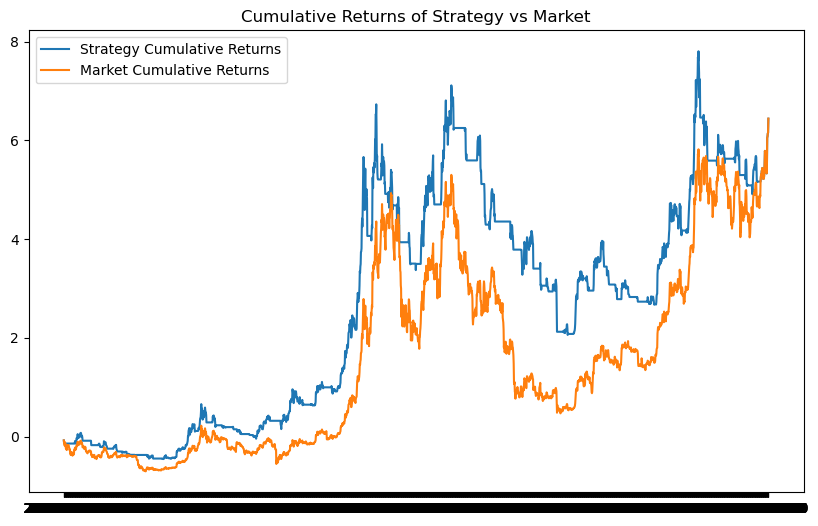

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設 data 中已經包含 short_mavg 和 long_mavg
# 計算 signal
data['signal'] = np.where(data['short_mavg'] > data['long_mavg'], 1.0, 0.0)

# 計算每日市場回報
data['market_returns'] = data['close'].pct_change()

# 計算策略回報：前一日的信號用於當前日的回報
data['strategy_returns'] = data['market_returns'] * data['signal'].shift(1)

# 計算累積回報
data['strategy_cumulative_returns'] = (1 + data['strategy_returns']).cumprod() - 1
data['market_cumulative_returns'] = (1 + data['market_returns']).cumprod() - 1

# 可視化累積回報
plt.figure(figsize=(10, 6))
plt.plot(data['strategy_cumulative_returns'], label='Strategy Cumulative Returns')
plt.plot(data['market_cumulative_returns'], label='Market Cumulative Returns')
plt.title('Cumulative Returns of Strategy vs Market')
plt.legend()
plt.show()

## 指標計算

In [34]:
# Calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

data['EMA10'] = EMA(data, 10)
data['EMA30'] = EMA(data, 30)
data['EMA200'] = EMA(data, 200)
data.head()

# Calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

data['ROC10'] = ROC(data['close'], 10)
data['ROC30'] = ROC(data['close'], 30)

# Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

data['MOM10'] = MOM(data['close'], 10)
data['MOM30'] = MOM(data['close'], 30)

# Calculation of relative strength index
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean(u[:period])  # first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean(d[:period])  # first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
    return 100 - 100 / (1 + rs)

data['RSI10'] = RSI(data['close'], 10)
data['RSI30'] = RSI(data['close'], 30)
data['RSI200'] = RSI(data['close'], 200)

# Calculation of stochastic oscillator

def STOK(close, low, high, n): 
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

data['%K10'] = STOK(data['close'], data['low'], data['high'], 10)
data['%D10'] = STOD(data['close'], data['low'], data['high'], 10)
data['%K30'] = STOK(data['close'], data['low'], data['high'], 30)
data['%D30'] = STOD(data['close'], data['low'], data['high'], 30)
data['%K200'] = STOK(data['close'], data['low'], data['high'], 200)
data['%D200'] = STOD(data['close'], data['low'], data['high'], 200)

In [35]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
data['MA21'] = MA(data, 10)
data['MA63'] = MA(data, 30)
data['MA252'] = MA(data, 200)
data.tail()

,open_time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
2638,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,2024-11-06 23:59:59.999,7.702283e+09,8434184,53243.884427,...,54.706144,91.343335,49.457646,95.256044,75.661564,96.978066,85.428958,70577.613,67434.546667,63562.93115
2639,2024-11-07,75571.99,76849.99,74416.00,75857.89,44869.422345,2024-11-07 23:59:59.999,3.391797e+09,5207722,21805.460295,...,54.767427,90.093849,72.942658,94.458777,86.921716,96.437701,92.053713,71167.181,67891.126667,63617.51485
2640,2024-11-08,75857.89,77199.99,75555.00,76509.78,36521.099583,2024-11-08 23:59:59.999,2.784449e+09,4877489,17555.393633,...,54.907238,93.340949,91.592711,96.218854,95.311225,97.552446,96.989404,71544.517,68420.252000,63665.96715
2641,2024-11-09,76509.78,76900.00,75714.66,76677.46,16942.079150,2024-11-09 23:59:59.999,1.294709e+09,2585264,8032.793270,...,54.943241,94.958702,92.797833,96.946474,95.874702,98.147056,97.379068,71977.789,68965.287667,63717.28445
2642,2024-11-10,76677.46,80080.00,76492.00,79731.97,39627.196509,2024-11-10 23:59:59.999,3.126252e+09,4675979,21321.876811,...,55.592358,97.372367,95.224006,98.069717,97.078349,98.880212,98.193238,72921.785,69538.353333,63794.49635


In [7]:
# 將 'date' 列設為索引
data.set_index('open_time', inplace=True)

In [8]:
#刪除不必要的欄位
if 'close_time' in data.columns:
    data = data.drop('close_time', axis=1)
if 'ignore' in data.columns:
    data = data.drop('ignore', axis=1)

In [9]:
# 刪除包含 NaN 的樣本
data = data.dropna()

In [39]:
data.to_csv("data_binance.csv")

## 資料視覺化

In [3]:
data = pd.read_csv('data_binance.csv')

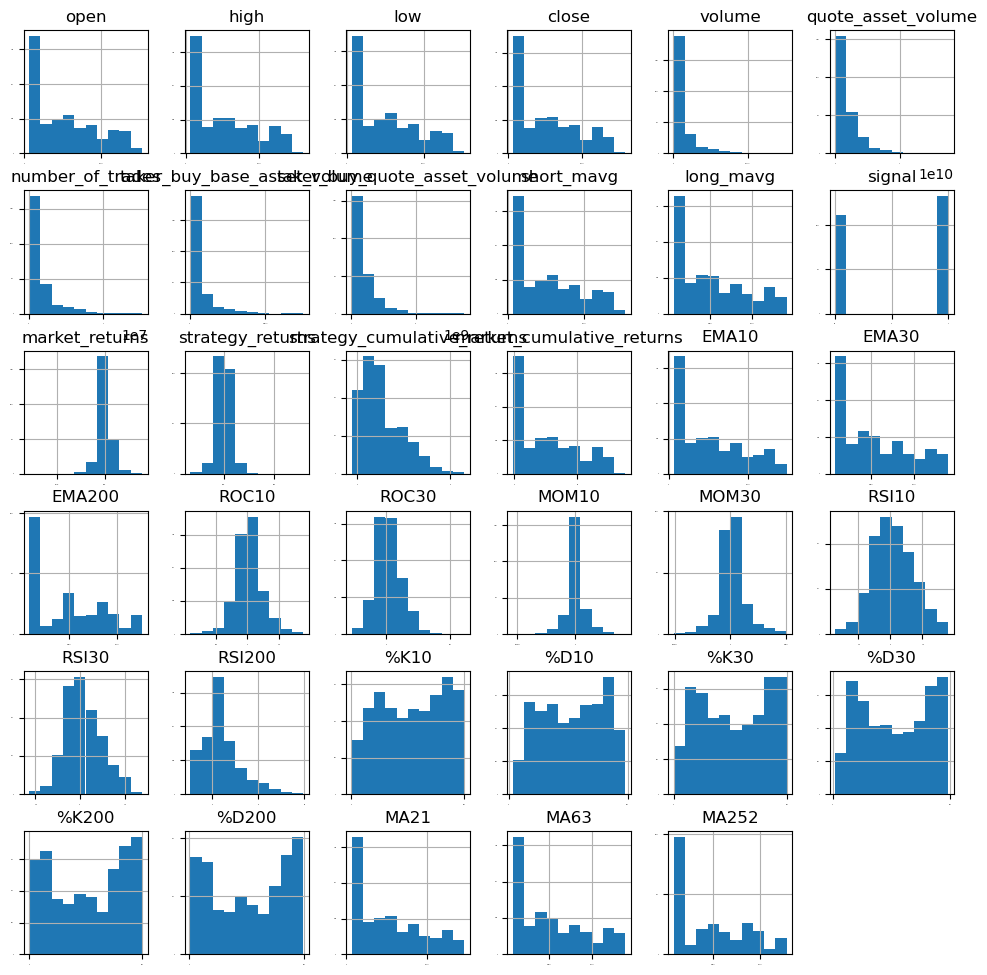

In [10]:
# histograms
data.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

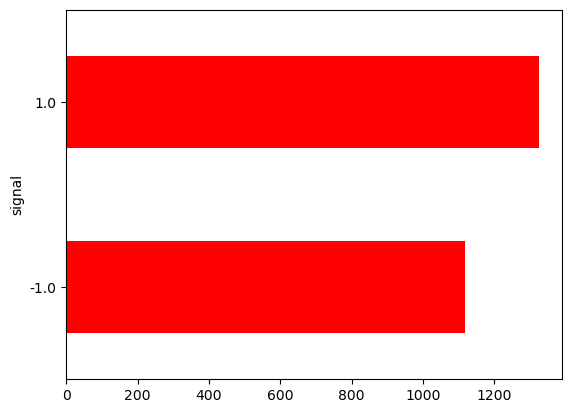

In [11]:
fig = plt.figure()
plot = data.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<Axes: title={'center': 'Correlation Matrix'}>

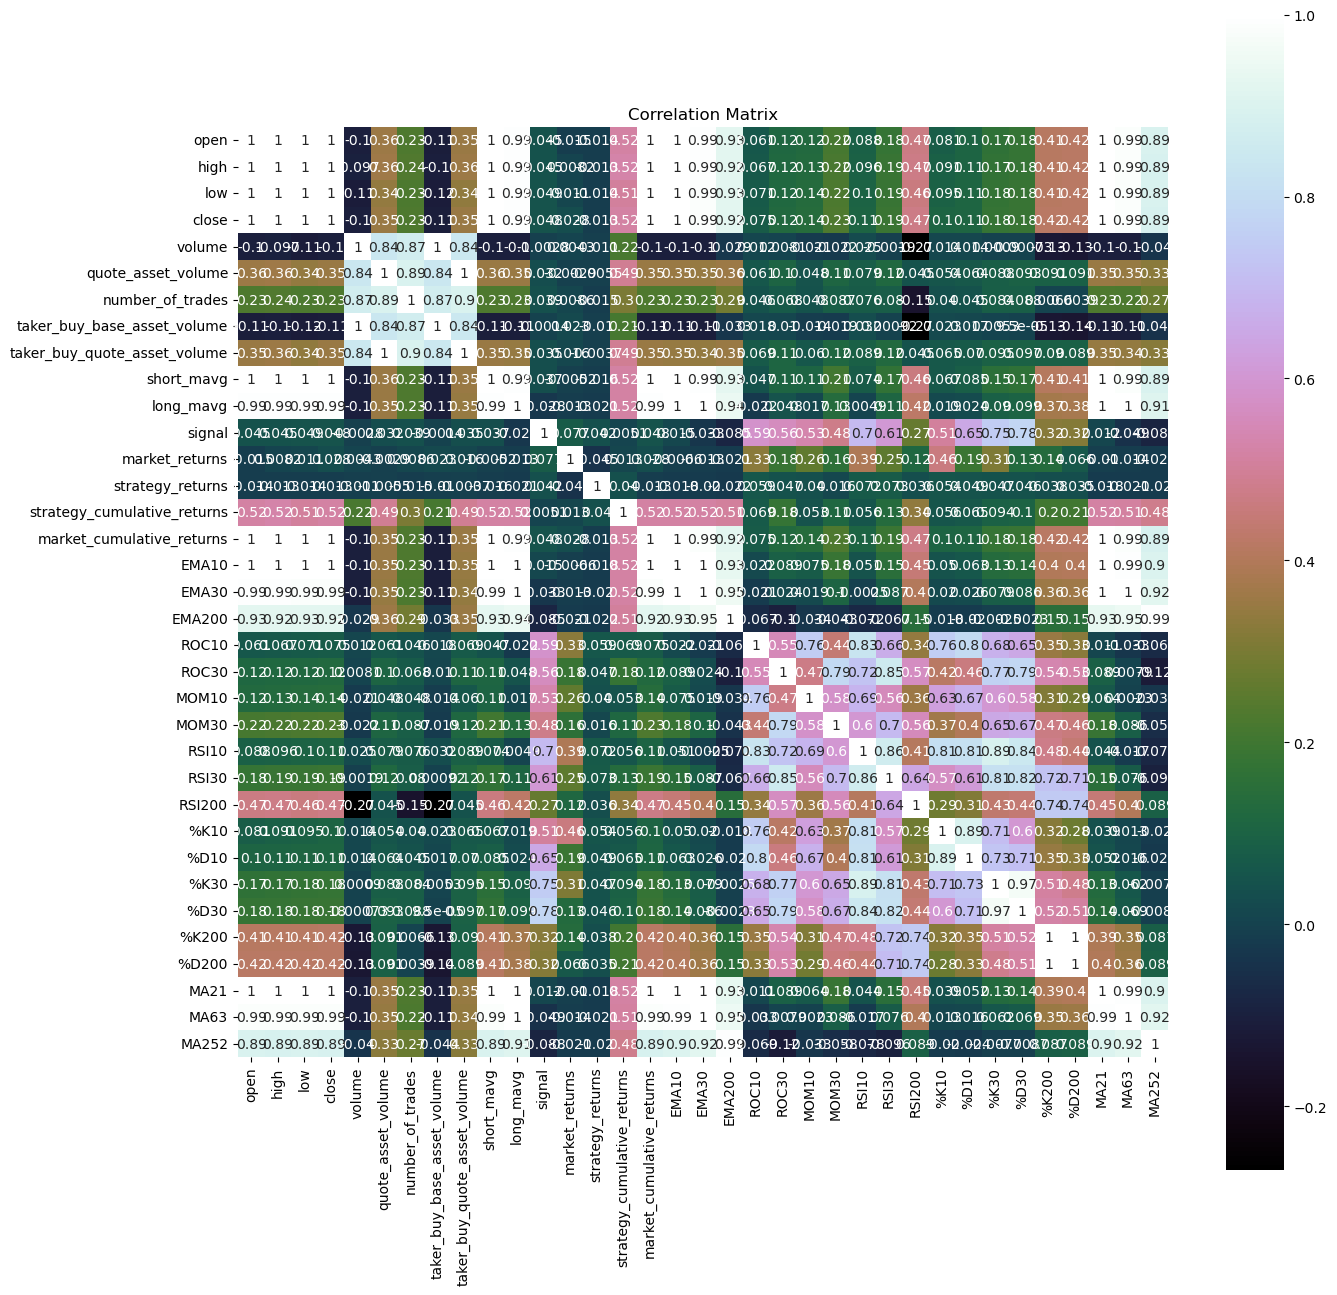

In [12]:
import seaborn as sns  # 導入 Seaborn
import matplotlib.pyplot as plt  # 確保也有導入 Matplotlib

# correlation
correlation = data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# 模型訓練

In [13]:
# 導入所需的庫
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# split out validation dataset for the end
subset_dataset= data.iloc[-100000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, data.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1, shuffle=False)


In [14]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
scoring = 'roc_auc'

In [15]:
# 導入所需的機器學習模型
from sklearn.linear_model import LogisticRegression  # 邏輯回歸
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 線性判別分析
from sklearn.neighbors import KNeighborsClassifier  # K 最近鄰
from sklearn.tree import DecisionTreeClassifier  # 決策樹
from sklearn.naive_bayes import GaussianNB  # 高斯朴素貝葉斯
from sklearn.neural_network import MLPClassifier  # 多層感知器（神經網絡）
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier  # 集成模型：AdaBoost、GBM、隨機森林

In [16]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [17]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score  # 導入 TimeSeriesSplit 和交叉驗證函數

results = []
names = []
num_folds = 5  # 設定分割的折數，通常較小（例如 5 或 3）
best_model = None
best_score = -float('inf')  # 初始化最好的 roc_auc 分數

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=num_folds)
    
    # 使用 f1_score 作為評分標準
    cv_results = cross_val_score(model, X_train, Y_train, cv=tscv, scoring='roc_auc')
    
    # 記錄結果
    results.append(cv_results)
    names.append(name)
    
    # 計算並顯示每個模型的 F1 分數
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    # 比較並選擇表現最好的模型
    if cv_results.mean() > best_score:
        best_score = cv_results.mean()
        best_model = model

# 輸出表現最好的模型
print(f"Best Model: {best_model} with roc_auc score: {best_score}")

LR: 0.636816 (0.074002)
LDA: 0.929114 (0.048692)


c:\Users\88695\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\88695\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\88695\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "c:\Users\88695\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\88695\anaconda3\Lib\site-packages\sklearn\utils\_response.py", line 210, in _get_response_values
    y_pred = prediction_method(X)
             ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\88695\anaconda3\Lib\site-packages\sklearn\neighbors\_classificatio

KNN: nan (nan)
CART: 0.766522 (0.092413)
NB: 0.564633 (0.068096)
NN: 0.505643 (0.028978)


c:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\88695\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\886

AB: 0.907580 (0.068529)
GBM: 0.963642 (0.011832)
RF: 0.946837 (0.013028)
Best Model: GradientBoostingClassifier() with roc_auc score: 0.9636422199918485


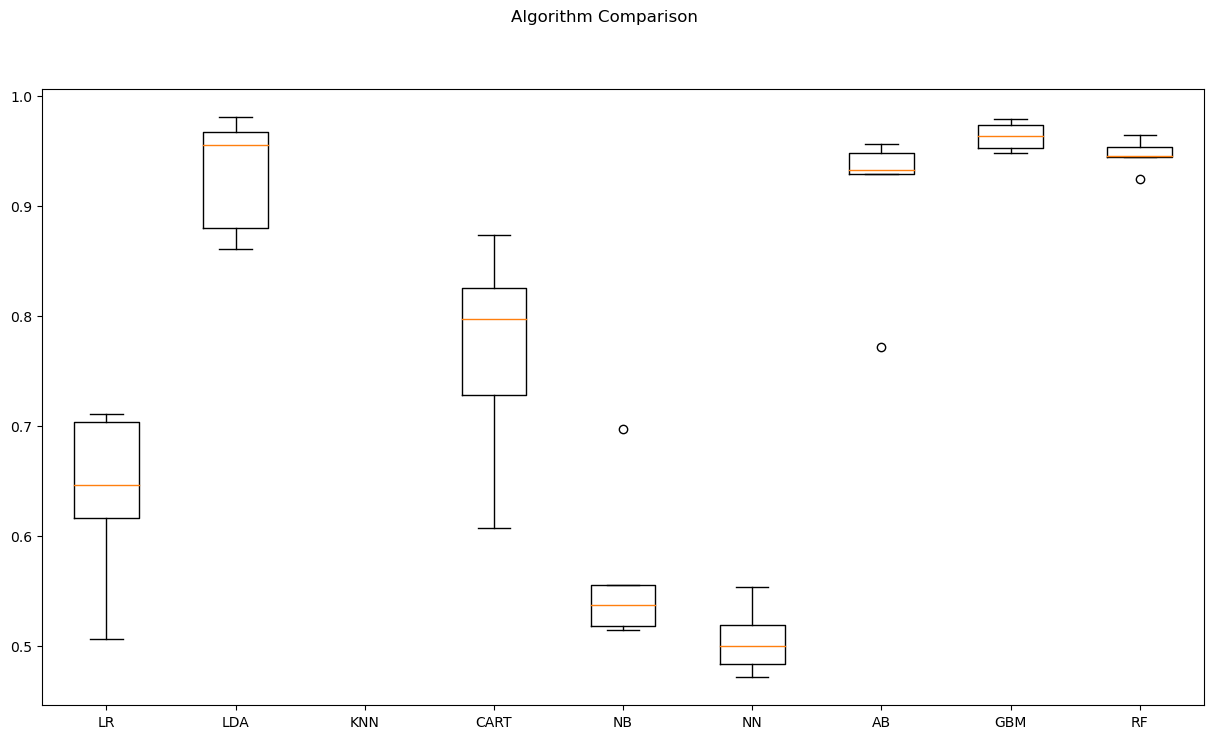

In [18]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

# 模型參數優化

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# 定義數據標準化 (可選)
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)

# 設定GBM的參數範圍
n_estimators = [50, 100, 200]  # 樹的數量
learning_rate = [0.01, 0.1, 0.2]  # 學習率
max_depth = [3, 5]  # 樹的深度
subsample = [0.7, 0.8]  # 子樣本比例

param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, 
                  max_depth=max_depth, subsample=subsample)

# 設置GBM模型
model = GradientBoostingClassifier()

# 設置K-fold交叉驗證
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# 設置Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# 打印最佳結果
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 打印每個參數組合的詳細結果
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']

for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

KeyboardInterrupt: 

# 模型評估

In [22]:
# prepare model
model = GradientBoostingClassifier(learning_rate= 0.2, max_depth= 3, n_estimators= 200, subsample = 0.8) 
model.fit(X_train, Y_train)

GradientBoostingClassifier(learning_rate=0.2, n_estimators=200, subsample=0.8)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.918200408997955
[[171  30]
 [ 10 278]]
              precision    recall  f1-score   support

        -1.0       0.94      0.85      0.90       201
         1.0       0.90      0.97      0.93       288

    accuracy                           0.92       489
   macro avg       0.92      0.91      0.91       489
weighted avg       0.92      0.92      0.92       489



<Axes: xlabel='Predicted', ylabel='Actual'>

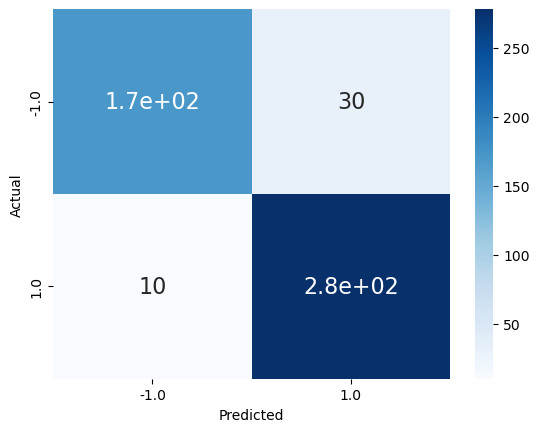

In [24]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

## 特徵重要度分析

Text(0.5, 0, 'Variable Importance')

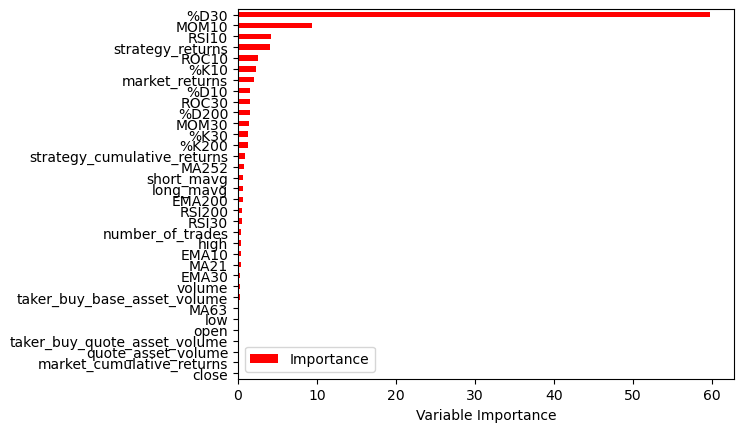

In [28]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

# 回測結果

<Axes: >

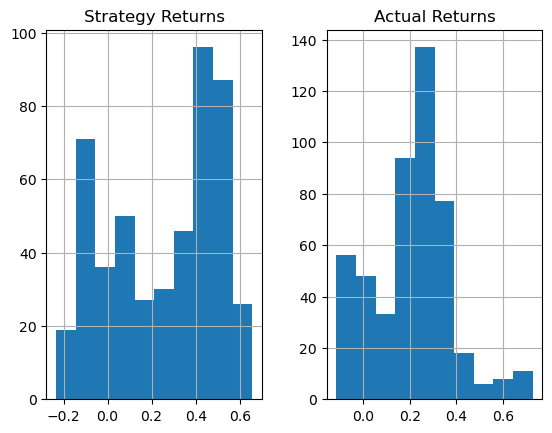

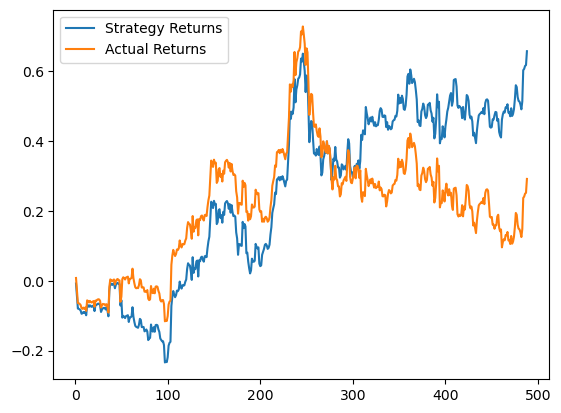

In [29]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [30]:
backtestdata

,open_time,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
0,2023-07-11,1.0,-1.0,NaN,NaN,NaN
1,2023-07-12,-1.0,-1.0,-0.007906,0.007906,-0.007906
2,2023-07-13,1.0,1.0,0.035360,-0.035360,-0.035360
3,2023-07-14,1.0,1.0,-0.036314,-0.036314,-0.036314
4,2023-07-15,1.0,1.0,-0.000742,-0.000742,-0.000742
...,...,...,...,...,...,...
484,2024-11-06,1.0,1.0,0.089373,0.089373,0.089373
485,2024-11-07,1.0,1.0,0.003783,0.003783,0.003783
486,2024-11-08,1.0,1.0,0.008594,0.008594,0.008594
487,2024-11-09,1.0,1.0,0.002192,0.002192,0.002192
